# Sensitivity Demonstration

* Author: J. Emmanuel Johnson
* Date: 28th August, 2019

## Introduction

In this demo, I will be looking at sensitivity measures for Gaussian processes with regards to emulation and sensitivity analysis. 

**Emulation** is when we use a machine learning model to take the place of a physical model for reasons such as computational cost. E.g. some physical models such as MODTRAN are very expensive (and complicated) to run and a ML model can possibly capture sufficiently enough non-linear interactions to capture the relationship between the inputs $\mathcal{X}$ and the outputs $\mathcal{Y}$. The ML model should be able to take samples from the input space $\mathcal{X}$ and produce samples within the output space $\hat{\mathcal{Y}}$ that are equal to or identical to the inputs in the real output space $\mathcal{Y}$.

An important way to check whether or not the emulator (the ML model) captures the relationships well is if we check using **sensitivity analysis**. SA provides us with a way to check how sensitivity a given input is for the outputs. So for example, let's say that $x_1$ has a high sensitivity and $x_2$ has a low sensitivity. If I perturb $x_1$ a little, then the output $y$ will change a lot but if I perturb $x_2$ a little, then the output of $y$ may not change a lot.

**Gradients** are an important mathematical interpretation of sensitivity. High gradients dictate areas of drastic change and high complexity, a.k.a. intuitively probable sensitivity regions. Not many machine learning algorithms have mathematically sound gradients (that are easy to calculate). In the case of some algorithms, such as kernel methods and Gaussian processes, do have easy to calculate gradients. For example in GPs, we simply need to take the derivative of the kernel function since we have a simple linear operation $f(x)=K\alpha$.

\begin{equation}
\frac{\partial f(x)}{\partial x^d} = \frac{\partial K}{\partial x^d}\alpha
\end{equation}

This means we have simple way to calculate the gradient (and hence the sensitivity) of the input values with our ML algorithm. Another advantage to GP algorithms is that we can make assumptions about our model which allows us to generalize well provided that our assumptions are correct. Furthermore, GPs work really well when there is limited data. In ML, 1000 data points aren't that many so many methods may not perform so well. But GPs act as regularized interpolators so classic GPs do relatively well under a small number of data.

## Experiment

In this notebook we will demonstrate how the GP algorithm performs

## Code

In [1]:
import os, sys
cwd = os.getcwd()
sys.path.insert(0, f'{cwd}/../../src')

from data.prosail import prosail_generator
from typing import Tuple
import numpy as np
import pandas as pd
import GPy
from emukit.core.interfaces import IModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.core import ContinuousParameter, ParameterSpace

import statsmodels.api as sm
import time as time
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Dataset I - Prosail-MODTRAIN

In this first demonstration, we will use the Prosail-MODTRAN Dataset

In [2]:
file_loc = f'{cwd}/../../data/phi_week/raw/'
spec_name = 'TOA_sensor_Radiance_PROSAIL-MODTRAN_LHS1000'
ext = '.txt'
df = pd.read_csv(file_loc + spec_name + ext)

In [26]:
X_params = df.iloc[:, :20]
y_spectra = df.iloc[:, 20:]


columns = [
    'skyl',
    'hspot',
    'tts',
    'tto',
    'psi',
    'lai',
    'angle',
    'psoil',
    'vCover',
    'N', 
    'Cab',
    'Cw',
    'Cm', 
    'O3STR',
    'H20STR',
    'VIS',
    'G', 
    'ASTMX',
    'SSA',
    'GNDALT'
    
]

var_cols = [
    'lai',
    'angle',
    'psoil',
    'vCover',
    'Cab',
    'Cw', 
    'Cm',
    'O3STR',
    'H20STR',
    'VIS',
    'G',
    'ASTMX',
    'SSA',
    'GNDALT'
]

X_params.columns = columns

X_params = X_params[var_cols]

In [27]:
X_params.shape, y_spectra.shape

((1000, 14), (1000, 1401))

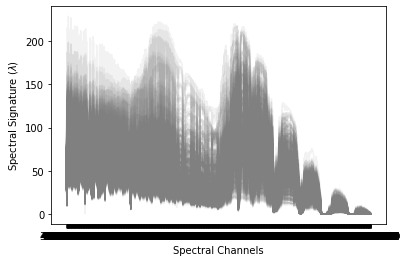

,lai,angle,psoil,vCover,Cab,Cw,Cm,O3STR,H20STR,VIS,G,ASTMX,SSA,GNDALT
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,3.962686,44.654485,0.488440,0.499750,39.560932,0.025897,0.025868,0.349466,2.487450,0.517275,0.794064,0.790201,0.878053,1.472333
std,2.332642,26.336007,0.290253,0.286468,23.062043,0.013822,0.014078,0.060640,0.920812,0.283820,0.117587,0.420378,0.075876,0.903927
min,0.000100,0.026400,0.001900,0.001400,0.055000,0.002000,0.002000,0.250000,1.000000,0.050000,0.600000,0.100000,0.750000,0.000000
25%,1.941700,21.878975,0.239400,0.254225,19.646575,0.014075,0.013575,0.299448,1.687685,0.273415,0.694590,0.438377,0.812335,0.690348
50%,3.949200,44.122900,0.483750,0.496700,39.096550,0.025550,0.025600,0.349300,2.474690,0.521685,0.795840,0.774545,0.879540,1.456105
75%,6.008725,67.824425,0.740225,0.741550,59.729400,0.037800,0.038425,0.401097,3.300813,0.755920,0.896038,1.134520,0.943900,2.224597
max,7.996800,89.944500,0.998700,0.999500,79.935200,0.050000,0.050000,0.450000,4.000000,1.000000,0.989000,1.500000,1.000000,3.000000


In [28]:
# # generate n_samples from prosail model
n_samples = 1_000
# X_params, y_spectra = prosail_generator(n_samples)


# generate plot of spectra
fig, ax = plt.subplots()

ax.plot(y_spectra.T, alpha=0.1, color='gray')
ax.set_xlabel('Spectral Channels')
ax.set_ylabel(r'Spectral Signature ($\lambda$)')
plt.show()

# input parameters X
X_params.describe()

### Dataset II - MODTRAN-HYDROLIGHT

In [91]:
file_loc = f'{cwd}/../../data/phi_week/raw/'
spec_name = 'TOA_sensor_Radiance_Hydrolight_NO SENSOR_1000nm'
ext = '.txt'
df = pd.read_csv(file_loc + spec_name + ext).T

In [92]:
df.iloc[:, :9].describe()

,0,1,2,3,4,5,6,7,8
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,2.963315,0.956892,0.349661,2.480136,0.535663,0.798243,0.787780,0.872960,1.570460
std,6.163853,1.578119,0.074759,1.100184,0.355365,0.144633,0.512095,0.096425,1.106648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367000,0.315000,0.276350,1.383200,0.200000,0.655260,0.295000,0.780940,0.425010
50%,0.675000,0.589000,0.349090,2.493500,0.554000,0.806630,0.781820,0.868980,1.623500
75%,0.937000,0.838000,0.423810,3.534900,0.891270,0.932760,1.285200,0.964050,2.645400
max,30.000000,9.750000,0.450000,4.000000,1.000000,0.989000,1.500000,1.000000,3.000000


The dataset given is missing **phichl**. The first column should have a max value of 0.02 and a min of 0.001. However, it has a min of 0.009 and a max of 30 (the parameters for **chl**).

In [93]:
df.iloc[:, -10:].describe()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,3.539596,3.424379,3.513541,3.482530,3.554359,3.489411,3.540272,3.520467,3.493649,3.486480
std,31.244326,31.278587,31.336117,31.378304,31.433576,31.473356,31.526636,31.571794,31.616727,31.663116
min,0.505010,0.492800,0.488990,0.490660,0.489800,0.482120,0.480350,0.476060,0.468240,0.467670
25%,0.761150,0.735510,0.744660,0.738070,0.753330,0.732560,0.744330,0.733150,0.726210,0.720130
50%,1.295900,1.249600,1.275900,1.263200,1.291000,1.259500,1.279400,1.267700,1.252100,1.247000
75%,3.083700,2.921000,3.054800,3.003100,3.103300,3.013100,3.084400,3.055200,3.022400,3.007800
max,986.190000,987.650000,989.120000,990.590000,992.060000,993.540000,995.020000,996.510000,998.000000,999.500000


The next bit of evidence is that the wavelengths behave the way they are supposed to; ranging from ~400 until ~1000.

In [94]:
# take only the first 9 columns
X_params = df.iloc[:, :9]
y_spectra = df.iloc[:, 9:]

# exclude phichl from the columns
columns = [
#     'phichl',
    'chl',
    'cdom',
    'O3STR',
    'H20STR',
    'VIS', 
    'G min',
    'ASTMX',
    'SSA',
    'GNDALT',
]

X_params.columns = columns
X_params.describe()

,chl,cdom,O3STR,H20STR,VIS,G min,ASTMX,SSA,GNDALT
count,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,2.963315,0.956892,0.349661,2.480136,0.535663,0.798243,0.787780,0.872960,1.570460
std,6.163853,1.578119,0.074759,1.100184,0.355365,0.144633,0.512095,0.096425,1.106648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.367000,0.315000,0.276350,1.383200,0.200000,0.655260,0.295000,0.780940,0.425010
50%,0.675000,0.589000,0.349090,2.493500,0.554000,0.806630,0.781820,0.868980,1.623500
75%,0.937000,0.838000,0.423810,3.534900,0.891270,0.932760,1.285200,0.964050,2.645400
max,30.000000,9.750000,0.450000,4.000000,1.000000,0.989000,1.500000,1.000000,3.000000


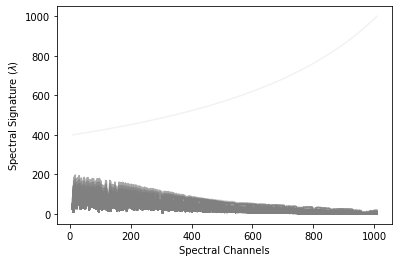

In [115]:
# # generate n_samples from prosail model
n_samples = 1_000
# X_params, y_spectra = prosail_generator(n_samples)


# generate plot of spectra
fig, ax = plt.subplots()

ax.plot(y_spectra.T, alpha=0.1, color='gray')
ax.set_xlabel('Spectral Channels')
ax.set_ylabel(r'Spectral Signature ($\lambda$)')
plt.show()


# Save Figures
save_loc = '../../figures/phi_week/'

save_name = 'spectra_modhy.png'
fig.savefig(save_loc + save_name)

### Preprocessing

We only apply a simple standardization of the inputs and remove the mean from the outputs. This is standard practice and particularly essential when dealing with kernel methods.

In [96]:
# standardize X
x_mean, x_std = X_params.mean(axis=0), X_params.std(axis=0)
X = (X_params - x_mean ) / x_std

# remove mean from y
y_mean = y_spectra.mean(axis=0)
y = (y_spectra - y_mean)

### Model - Gaussian Process

We will use a Gaussian process model from the [GPy]() package and we will wrap the model using the [Emukit]() package. The GP algorithm is a standard GP regression model. The wrapper simply allows us to calculate the Sobel indices (a.k.a. the standard method for calculating sensitivity indices) for models in general.

We use the radial basis function (RBF) kernel using variable length scales (i.e. there is a length scale parameter for every input feature for $X$).

\begin{equation}
K(\mathbf{x,x'}) = \exp\left( - \frac{1}{2} \sum_{d=1}^{D} \frac{1}{\sigma_d^2}(x_d-x_d')^2 \right)
\end{equation}


**Note**: Our outputs for $\mathcal{Y}$ are multioutputs (a.k.a. $Y \in \mathcal{R}^{N \times P}$ where $N$ is the number of samples and $P$ are the number of outputs. We don't want to fit a multi-output GP to all 2101 samples so we will reduce the dimensionality of the outputs $P$ to $p$, where $P >> p$, using the PCA algorithm.

In [97]:
class GPyModel(IModel):
    """
    This is a thin wrapper around GPy models to allow users to plug GPy models into Emukit
    """
    def __init__(self, X_init: np.ndarray, Y_init: np.ndarray, 
                 kernel: str = 'ard', n_restarts: int = 1, n_components=10, 
                 random_state=123, verbose=0):
        """
        :param gpy_model: GPy model object to wrap
        :param n_restarts: Number of restarts during hyper-parameter optimization
        """
        # transform data
        self.pca_model = PCA(n_components=n_components, random_state=random_state)
        Y_init = self.pca_model.fit_transform(Y_init)
        
        self._X = X_init
        self._Y = Y_init
        
        if kernel == 'ard':
            ARD=True
        else:
            ARD = False
        
        kernel = GPy.kern.RBF(X_init.shape[-1], ARD=ARD)
        self.model = GPy.models.GPRegression(X=X_init, Y=Y_init, kernel=kernel)
        self.n_restarts = n_restarts
        self.verbose = verbose


    def predict(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        :param X: (n_points x n_dimensions) array containing locations at which to get predictions
        :return: (mean, variance) Arrays of size n_points x 1 of the predictive distribution at each input location
        """
        ymean, yvar = self.model.predict(X)
        
        # Inverse transform Y
        ymean = self.pca_model.inverse_transform(ymean)
        return ymean, yvar

    def get_prediction_gradients(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        :param X: (n_points x n_dimensions) array containing locations at which to get gradient of the predictions
        :return: (mean gradient, variance gradient) n_points x n_dimensions arrays of the gradients of the predictive
                 distribution at each input location
        """
        d_mean_dx, d_variance_dx = self.model.predictive_gradients(X)
        
        # Inverse Transform Der Outputs
        d_mean_dx = self.pca_model.inverse_transform(d_mean_dx)
        return d_mean_dx, d_variance_dx

    def set_data(self, X: np.ndarray, Y: np.ndarray) -> None:
        """
        Sets training data in model
        :param X: New training features
        :param Y: New training outputs
        """
        # Transform 
        Y = self.pca_model.transform(Y)
        self.model.set_XY(X, Y)

    def optimize(self):
        """
        Optimizes model hyper-parameters
        """
        if self.n_restarts == 0:
            self.model.optimize(messages=self.verbose)
        elif self.n_restarts >= 1:
            self.model.optimize_restarts(self.n_restarts, verbose=self.verbose, robust=True)

    @property
    def X(self) -> np.ndarray:
        """
        :return: An array of shape n_points x n_dimensions containing training inputs
        """
        return self._X

    @property
    def Y(self) -> np.ndarray:
        """
        :return: An array of shape n_points x 1 containing training outputs
        """
        return self._Y

#### Training

In [104]:
# MODEL PARAMETERS
n_restarts   = 10   # helps to avoids local minima
verbose      = 1    # updates on training progress
n_components = 7    # number of components for spectra
random_state = 123  # for reproducibility
kernel       = 'ARD'

# initialize GPR model
gp_model = GPyModel(
    X.values, y.values, 
    n_restarts=n_restarts, 
    verbose=verbose, 
    n_components=n_components,
    random_state=random_state,
    kernel=kernel
)

# fit to data
t0 = time.time()
gp_model.optimize()
t1 = time.time() - t0

# time taken to train
print(f"Training Time: {t1:.3f} secs")

Optimization restart 1/10, f = -15627.20184631154
Optimization restart 2/10, f = 47055.55103274316


 /home/emmanuel/.conda/envs/2019_gp_sa/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square
 /home/emmanuel/.conda/envs/2019_gp_sa/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/emmanuel/.conda/envs/2019_gp_sa/lib/python3.6/site-packages/GPy/kern/src/rbf.py:54: RuntimeWarning:invalid value encountered in multiply
 /home/emmanuel/.conda/envs/2019_gp_sa/lib/python3.6/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /home/emmanuel/.conda/envs/2019_gp_sa/lib/python3.6/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


Optimization restart 3/10, f = 47835.302596285685
Optimization restart 4/10, f = 48385.87910537598
Optimization restart 5/10, f = -4152.199463633703
Optimization restart 6/10, f = 48150.79387691105
Optimization restart 7/10, f = 48660.14788302043
Optimization restart 8/10, f = -3991.252563856181
Optimization restart 9/10, f = -4178.403247759529
Optimization restart 10/10, f = -15626.611740512602
Training Time: 274.522 secs


#### Testing

Technically, we have used all of our data to train the GP so this is not a testing procedure. However, it is good practice to check how well our model did on the training phase.

In [110]:
# get predictions for training data
ypred, yvar = gp_model.predict(X.values)

# use linear regression to check how well we did
results = sm.OLS(y.values.flatten(), ypred.flatten()).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.534e+10
Date:                Thu, 29 Aug 2019   Prob (F-statistic):               0.00
Time:                        10:21:18   Log-Likelihood:             7.0445e+05
No. Observations:             1002001   AIC:                        -1.409e+06
Df Residuals:                 1002000   BIC:                        -1.409e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0000   5.32e-06   1.88e+05      0.0

We get an R$^2$ value of 0.949 which is really good. So we have effectively emulated the Prosail model given the data.

### Sensitivity


#### Derivative (Gradient Sensitivity Analysis)

For the first part of the sensitivity analysis, we take the gradient of the prediction mean function which is simply the gradient of the kernel function $K$. Fortunately, this is built into the GPy library so we do not need to do any complex calculations.

To go from gradient to sensitivity, we will sum all of the 

\begin{equation}
d
\end{equation}

In [106]:
# calcualte the gradient
t0 = time.time()
mu_der, var_der = gp_model.get_prediction_gradients(X.values)
t1 = time.time() - t0

# calculate the sensitivty

# time taken for gradient
print(f"GP Der Time: {t1:.3f} secs")

GP Der Time: 1.944 secs


#### Sobel Indices

For the second part of the sensitivity analysis, we will use the Emukit package to calculate the Sobel Indices. The derivative-based sensitivity analysis is a first order approximation of the sensitivity so we will only compare this with the main effects of the Sobel Indices, also a first order approximation of the sensitivity. 

**Note**: We will use MonteCarlo estimates embedded within the package itself to estimate the Sobel indices.

In [107]:
# create parameter space
params = list()

for icolumn in X.columns.values:

    # Add to parameter list
    params.append(
        ContinuousParameter(str(icolumn), X[icolumn].min(), X[icolumn].max())
    )

space = ParameterSpace(params)

# SOBEL INDICES PARAMETERS
np.random.seed(10)  # for reproducibility
num_mc = 2000  # Number of MC samples

# Initialize MC Sens Model
sensitivity = MonteCarloSensitivity(model=gp_model, input_domain=space)

# Compute sensitivity effects
t0 = time.time()
main_effects, total_effects, _ = sensitivity.compute_effects(
    num_monte_carlo_points = int(num_mc), 
)
t1 = time.time() - t0

# time taken
print(f"MC ({num_mc} samples) Time: {t1:.3f} secs")

MC (2000 samples) Time: 3.965 secs


#### Visualization

To visualize the sensitivity measures, we will plot take the absolute value of each of the values and then divide by the maximum. This allows us to plot the relative sensitivity of each input variable. I have coloured each of the inputs individually so that it is easier to distringuish which variables are more impactful.

In [108]:
MYCOLORS = [
#     'blue', 
    'orange', 
    'yellow', 
    'purple', 
    'limegreen', 
    'lightblue', 
    'red', 
    'blue',
    'orange',
    'yellow',
]

def plot_sens_area(df: pd.DataFrame, title: str) -> None:
    # Initialize Figures
    fig, ax = plt.subplots()

    # Transform Data into percentage
    # print(df.describe())
    df = df.abs()
#     df[df < 0] = 0.0
    df = df.divide(df.sum(axis=1), axis=0)
    # print(df.describe())
    

    # Stacked Bar Chart
    df.plot.area(ax=ax, color=MYCOLORS)
    ax.margins(0, 0)
    ax.set_xlabel("Wavelength [nm]")
    ax.set_ylabel("Total SI [%]")
#     plt.tight_layout()
    ax.set_title(title)
    plt.show()

    return fig

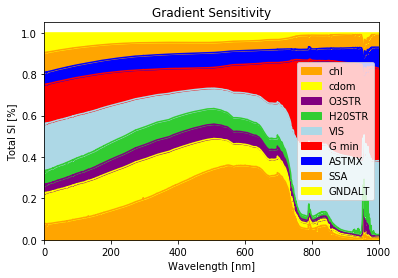

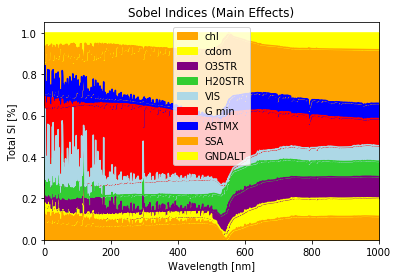

In [111]:
# dataframe for easier processing
main_df = pd.DataFrame(main_effects)
der_df = pd.DataFrame((mu_der**2).mean(axis=0).T, columns=main_df.columns)

# plot Gradient 
title = 'Gradient Sensitivity'
fig_der = plot_sens_area(der_df, title)

# plot Sobel
title = 'Sobel Indices (Main Effects)'
fig_sobel = plot_sens_area(main_df, title)

### Interpretation

It looks very similar in the relative sense. The gradient-sens seems to have some the variables CM,CW with less impact in the spectral range of 750-1500 and the variable LAI has more impact in the range of 300-850. However, the relative impact remains constant for both methodologies

#### Saving

In [114]:
# Save Data
save_loc = '../../data/phi_week/'
save_name = 'gp_sens_modhy.mat'
key = 'derivative'

der_df.to_hdf(save_loc + save_name, key='derivative', mode='w')
main_df.to_hdf(save_loc + save_name, key='sobel', model='a')

# Save Figures
save_loc = '../../figures/phi_week/'

save_name = 'gp_derivative_modhy.png'
fig_der.savefig(save_loc + save_name)

save_name = 'gp_sobel_modhy.png'
fig_sobel.savefig(save_loc + save_name)